# Example code for using session.Session

**Note:** This notebook covers several relevant methods of the `Session` and `Stim` objects, detailing some of their arguments, as well. For more details, take a look at the docstring associated with a method of interest.

**Import notes:** 

* These packages should be present if installing the conda environment from `osca.yml`. 
* `util` is a [Github repo](https://github.com/colleenjg/util/tree/osca_mult) of mine, and the correct branch `osca_mult` is automatically installed from `osca.yml`. Errors internal to the codebase involving `util` code and occurring *after* new changes have been pulled from the `OpenScope_CA_Analysis` repo *may* be due to an update of the `osca_mult` branch of `util`. Though I will try to avoid this, consider updating the utility under those circumstances.

In [1]:
import sys
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sys.path.extend([".", ".."])
from analysis import session
from sess_util import sess_gen_util, sess_plot_util
from util import gen_util, logger_util, plot_util

## Set paths to main data directory and the mouse dataframe

In [2]:
datadir = Path("..", "..", "data", "OSCA")
mouse_df = Path("..", "mouse_df.csv")

If you wish to use the same formatting style (and logging format) as I do:

In [3]:
plot_util.linclab_plt_defaults()

## 1. Basics of initializing a Session object

After creating the session, you must run `self.extract_info()`. 
This wasn't amalgamated into the `__init__` to reduce the amount of information needed to just create a session object.

### Loading ROI/running/pupil info
You can load this information when you call `self.extract_info()` or manually later by calling `self.load_roi_info()`, `self.load_run_data()` and `self.load_pup_data()`. 

In [4]:
sess = session.Session(datadir, 764704289, mouse_df=mouse_df)
sess.extract_info(full_table=False, roi=True, run=True, pupil=True) 

Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Loading pupil info...


In [5]:
sess.stim_df

,stimulus_type,stimulus_template_name,unexpected,gabor_frame,gabor_kappa,gabor_mean_orientation,gabor_number,gabor_locations_x,gabor_locations_y,gabor_sizes,...,square_proportion_flipped,start_frame_stim,stop_frame_stim,num_frames_stim,start_frame_twop,stop_frame_twop,num_frames_twop,start_time_sec,stop_time_sec,duration_sec
0,grayscreen,grayscreen,NaN,,NaN,NaN,NaN,[],[],[],...,NaN,0,1800,1800,143,1046,903,14.277090,44.301717,30.024627
1,gabors,gabors,0.0,A,16.0,135.0,30.0,"[-0.998732530996428, -0.7988942745979938, -0.0...","[-0.936204215614872, -0.48115197167416995, -0....","[293, 392, 392, 323, 280, 396, 316, 363, 226, ...",...,NaN,1800,1818,18,1046,1055,9,44.301717,44.602241,0.300524
2,gabors,gabors,0.0,B,16.0,135.0,30.0,"[-0.8273358833992613, -0.32202169430120714, -0...","[-0.6021449948480063, -0.6653905125829843, -0....","[313, 319, 262, 228, 400, 210, 264, 218, 308, ...",...,NaN,1818,1836,18,1055,1064,9,44.602241,44.902563,0.300322
3,gabors,gabors,0.0,C,16.0,135.0,30.0,"[-0.1439318404380644, -0.9639223437829889, -0....","[-0.725093701321675, -0.021010443830197678, -0...","[396, 212, 277, 210, 390, 329, 406, 317, 358, ...",...,NaN,1836,1854,18,1064,1073,9,44.902563,45.202768,0.300204
4,gabors,gabors,0.0,D,16.0,135.0,30.0,"[-0.1981534893873622, -0.7603480104179756, -0....","[-0.23152862741244445, -0.41875478323604776, -...","[326, 244, 208, 212, 251, 242, 341, 299, 406, ...",...,NaN,1854,1872,18,1073,1082,9,45.202768,45.503007,0.300240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8839,visflow,visflow_right,0.0,,NaN,NaN,NaN,[],[],[],...,0.00,249960,250020,60,125552,125582,30,4183.741890,4184.742721,1.000831
8840,visflow,visflow_right,1.0,,NaN,NaN,NaN,[],[],[],...,0.25,250020,250080,60,125582,125612,30,4184.742721,4185.743529,1.000808
8841,visflow,visflow_right,1.0,,NaN,NaN,NaN,[],[],[],...,0.25,250080,250140,60,125612,125642,30,4185.743529,4186.744364,1.000835
8842,visflow,visflow_right,1.0,,NaN,NaN,NaN,[],[],[],...,0.25,250140,250200,60,125642,125672,30,4186.744364,4187.745223,1.000860


### Some information contained in the session object

Note: `Stim` objects (subclasses: `Gabors`, `Visflow`, `Grayscr`) are a separate class from `Session` objects. However, each can 
by accessed from the other using:
- from `Session objects`: `self.stims`, `self.gabors`, `self.visflow`
- from `Stim objects`: `self.sess`

In [6]:
print(f"number of rois: {sess.get_nrois()}")
print(f"mouse number: {sess.mouse_n}")
print(f"mouse ID: {sess.mouseid}")
print(f"gabor object: {sess.gabors}")
print(f"2p frames per sec: {sess.twop_fps:.2f}")
print(f"stimulus frames per sec: {sess.stim_fps:.2f}")

number of rois: 628
mouse number: 6
mouse ID: 413663
gabor object: Gabors (stimulus from session 764704289)
2p frames per sec: 30.08
stimulus frames per sec: 59.95


## 2. Identifying segments of interest

From a `Session`'s `Stim`, you can get a list of segments that fit a specific criterion, e.g. **U segments** (unexpected, 3rd segment).

In [7]:
gab_seg_ns = sess.gabors.get_segs_by_criteria(gabk=16, gabfr=3, unexp=1, by="seg")

Then, you can access the frame numbers. 

**Note:** Specifying `ch_fl` (check flanks) ensures that only frame numbers whose flanks are within the recording are returned. In other words, any frame number too close to the start of end of the recording (based on `pre`/`post` values), will be dropped.


In [8]:
pre = 1.0
post = 1.0
twop_fr_ns = sess.gabors.get_fr_by_seg(gab_seg_ns, start=True, ch_fl=[pre, post], fr_type="twop")["start_frame_twop"]
stim_fr_ns = sess.gabors.get_fr_by_seg(gab_seg_ns, start=True, ch_fl=[pre, post], fr_type="stim")["start_frame_stim"]

You can now get the **ROI/running/pupil data** corresponding these reference frames and specified `pre`/`post` periods (in sec). 

In [9]:
roi_data_df = sess.gabors.get_roi_data(twop_fr_ns, pre, post, scale=True)
run_data_df = sess.gabors.get_run_data(stim_fr_ns, pre, post, scale=True)
pup_data_df = sess.gabors.get_pup_diam_data(twop_fr_ns, pre, post, scale=True)

You can also directly obtain statistics on the data of interest

In [10]:
roi_stats_df = sess.gabors.get_roi_stats_df(
    twop_fr_ns, pre, post, integ=True, stats="mean", error="sem", byroi=False)

In [11]:
roi_stats_df

datatype               roi_traces
nan_rois_removed              yes
scaled                         no
baseline                       no
integrated                    yes
smoothing                      no
fluorescence                  dff
general ROIs sequences           
stats   None stat_mean   0.026752
             error_SEM   0.000911

Data and statistics are returned in a hierarchical dataframe with **columns** and **indices**.

This has the advantage of allowing metadata to be stored in dummy columns, however extracting data from these dataframes can be tricky, syntaxically.

In [12]:
roi_data_df

datatype                   roi_traces
nan_rois_removed                  yes
scaled                            yes
baseline                           no
integrated                         no
smoothing                          no
fluorescence                      dff
ROIs sequences time_values           
0    0         -1.000000    -0.009556
               -0.966102    -0.644810
               -0.932203    -0.214521
               -0.898305    -0.116127
               -0.864407    -0.318214
...                               ...
643  95         0.864407     0.050568
                0.898305     0.445153
                0.932203     0.108850
                0.966102     0.116475
                1.000000     0.213779

[3617280 rows x 1 columns]

To **extract a numpy array** with the correct dimensions from a hierarchical dataframe, you can use the following utility.

Here, each index level, then column level becomes an axis, **i.e. ROIs x sequences x time_values** (In this case, `squeeze_cols` is set to True to prevent each dummy column from becoming an axis.)

In [13]:
roi_data = gen_util.reshape_df_data(roi_data_df, squeeze_cols=True)
print("ROI data shape: {} ROIs x {} sequences x {} time values".format(*roi_data.shape))

ROI data shape: 628 ROIs x 96 sequences x 60 time values


You can also retrieve the time stamps for each frame.

In [14]:
xran = roi_data_df.index.unique("time_values")

Finally, we can plot each ROIs mean activity across sequences, as well as a mean across ROIs.

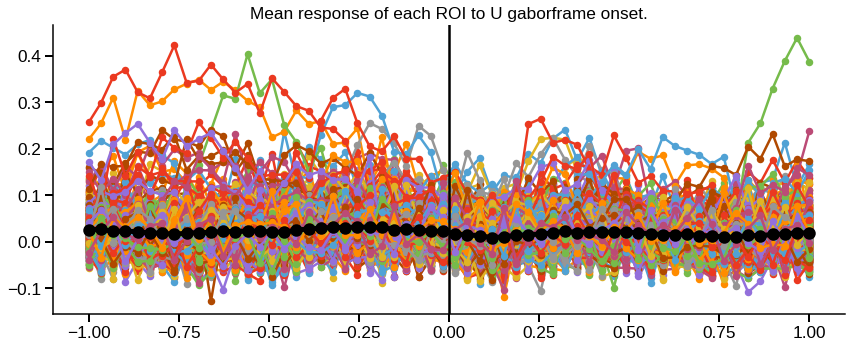

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 5))
_ = ax.plot(xran, np.mean(roi_data, axis=1).T, marker=".") # mean per ROI
_ = ax.plot(xran, np.mean(np.mean(roi_data, axis=1).T, axis=1), 
            lw=5, c="k", marker="o") # mean across ROIs
_ = ax.axvline(0, c="k")
_ = ax.set_title("Mean response of each ROI to U gaborframe onset.")

### The same steps apply for Visflow

In [16]:
from sess_util import sess_data_util
import importlib
importlib.reload(sess_data_util)

<module 'sess_util.sess_data_util' from '../sess_util/sess_data_util.py'>

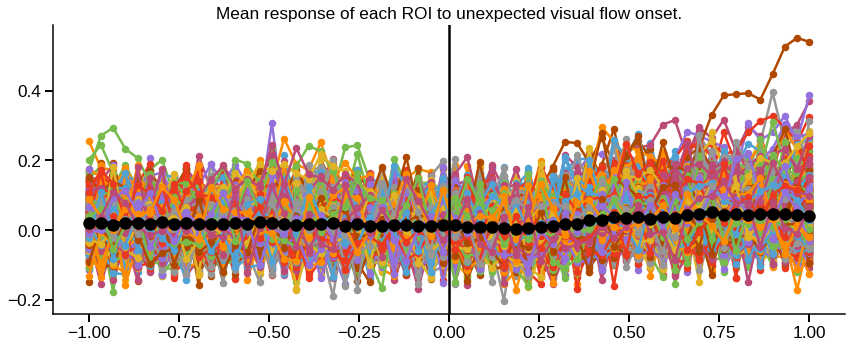

In [17]:
visflow_seg_ns = sess.visflow.get_segs_by_criteria(visflow_size=128, unexp=1, remconsec=True, by="seg")

pre = 1.0
post = 1.0
twop_fr_ns = sess.visflow.get_fr_by_seg(
    visflow_seg_ns, start=True, ch_fl=[pre, post], fr_type="twop")["start_frame_twop"]
stim_fr_ns = sess.visflow.get_fr_by_seg(
    visflow_seg_ns, start=True, ch_fl=[pre, post], fr_type="stim")["start_frame_stim"]

roi_data_df = sess.visflow.get_roi_data(twop_fr_ns, pre, post, scale=True)
roi_data = gen_util.reshape_df_data(roi_data_df, squeeze_cols=True)
xran = roi_data_df.index.unique("time_values")

fig, ax = plt.subplots(1, figsize=(12, 5))
_ = ax.plot(xran, np.mean(roi_data, axis=1).T, marker=".") # mean per ROI
_ = ax.plot(xran, np.mean(np.mean(roi_data, axis=1).T, axis=1), 
            lw=5, c="k", marker="o") # mean across ROIs
_ = ax.axvline(0, c="k")
_ = ax.set_title("Mean response of each ROI to unexpected visual flow onset.")

## 3. Additional tips on indexing a hierarchical dataframe

In [18]:
# getting columns
roi_data_series = roi_data_df["roi_traces"]

# getting specific ROIs (0, 3, 4)
roi_data_specific_rois = roi_data_df.loc[([0, 3, 4])]

# getting specific sequences (0, 3, 4 - any ROI) <- second order index, so requires a pandas slice
roi_data_specific_seqs = roi_data_df.loc[(pd.IndexSlice[:, [0, 3, 4]]), ]

# using both index and columns
roi_data_specific = roi_data_df.loc[(pd.IndexSlice[:, [0, 3, 4]]), ("roi_traces", "yes")]
roi_data_specific

scaled                           yes
baseline                          no
integrated                        no
smoothing                         no
fluorescence                     dff
ROIs sequences time_values          
0    0         -1.000000    0.045433
               -0.966102   -0.303140
               -0.932203   -0.301464
               -0.898305   -0.219794
               -0.864407    0.065587
...                              ...
643  4          0.864407   -0.513739
                0.898305   -0.143983
                0.932203    0.000693
                0.966102    0.140502
                1.000000    0.283351

[113040 rows x 1 columns]

### 4. Retrieving several Session objects, based on criteria

This function keeps track of which Sessions or Mice must be left out (e.g., due to a problem with the session data or the mouse didn't see the stimulus of interest <- the latter only comes up with pilot data).

In [19]:
omit_sess, omit_mice = sess_gen_util.all_omit(runtype="prod")

You can now retrieve the mouse number, session number and ID that fit specific the criteria, 

e.g., **session number 1, 2 or 3**, **production**, **dendritic plane**

In [20]:
mouse_ns, sess_ns, sessids = sess_gen_util.get_sess_vals(
    mouse_df, ["mouse_n", "sess_n", "sessid"], sess_n=[1, 2, 3], runtype="prod", plane="dend", omit_sess=omit_sess, 
    omit_mice=omit_mice)

In [21]:
print("\n".join([f"mouse {m}: {sid} (session {n})" for m, sid, n in zip(mouse_ns, sessids, sess_ns)]))


mouse 6: 764704289 (session 1)
mouse 6: 765193831 (session 2)
mouse 6: 766502238 (session 3)
mouse 8: 777914830 (session 1)
mouse 8: 778864809 (session 2)
mouse 8: 779650018 (session 3)
mouse 9: 826187862 (session 1)
mouse 9: 826773996 (session 2)
mouse 9: 827833392 (session 3)
mouse 10: 826338612 (session 1)
mouse 10: 826819032 (session 2)
mouse 10: 828816509 (session 3)
mouse 11: 823453391 (session 1)
mouse 11: 824434038 (session 2)
mouse 11: 825180479 (session 3)


You can now **initialize the Sessions** using this function which does the additional extraction steps automatically.

In [22]:
dend_sessions = sess_gen_util.init_sessions(
    sessids[:5], datadir, mouse_df, full_table=False, omit=True, runtype="prod", 
    roi=True, run=True
)

soma_sessions = sess_gen_util.init_sessions(
    [758519303], datadir, mouse_df, full_table=False, omit=True, runtype="prod", 
    roi=True, run=True
)


Creating session 764704289...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 764704289.

Creating session 765193831...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 765193831.

Creating session 766502238...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 766502238.

Creating session 777914830...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 777914830.

Creating session 778864809...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 778864809.

Creating session 758519303...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 758519303.


Then run through the sessions and do whatever with them.

In [23]:
for sess in dend_sessions + soma_sessions:
    print(f"Session ID: {sess.sessid} (mouse {sess.mouse_n}, session {sess.sess_n})")
    for stimtype in ["visflow", "gabors"]:
        stim = sess.get_stim(stimtype)
        segs = stim.get_segs_by_criteria(
            visflow_size=128, unexp=1, gabk=16, gabfr=3, by="seg", 
            remconsec=(stimtype == "visflow")
            )
        print(f"    {stimtype}: {len(segs)} sequences")

Session ID: 764704289 (mouse 6, session 1)
    visflow: 33 sequences
    gabors: 96 sequences
Session ID: 765193831 (mouse 6, session 2)
    visflow: 34 sequences
    gabors: 98 sequences
Session ID: 766502238 (mouse 6, session 3)
    visflow: 29 sequences
    gabors: 94 sequences
Session ID: 777914830 (mouse 8, session 1)
    visflow: 32 sequences
    gabors: 83 sequences
Session ID: 778864809 (mouse 8, session 2)
    visflow: 29 sequences
    gabors: 88 sequences
Session ID: 758519303 (mouse 1, session 1)
    visflow: 31 sequences
    gabors: 94 sequences


### 5. Retrieving ROI masks from session.

Boolean ROI masks can be obtained for Session.

For **dendritic sessions**, the Session is built to assume that `EXTRACT` (not `allen`) ROI data is to be used. This can be checked by checking `self.dend`. As long as `self.dend` is properly set, the correct masks will be loaded.


In [24]:
dend_sess = dend_sessions[0]
print(f"Dendritic session, ROI type: {dend_sess.dend}")

soma_sess = soma_sessions[0]
print(f"Somatic session, ROI type: {soma_sess.dend}")

Dendritic session, ROI type: extr
Somatic session, ROI type: allen


Masks can be loaded as follows, with dimensions: **ROI x height x width**, retrieving only masks for ROIs that are valid for dF/F traces.

In [25]:
dend_mask = dend_sess.get_roi_masks()
soma_mask = soma_sess.get_roi_masks()

Or if all masks are needed, the attributes can simply be retrieved.

In [26]:
dend_mask_all = dend_sess.roi_masks
soma_mask_all = soma_sess.roi_masks

One way to check which ROIs are not valid, is using `self.get_nanrois()`

In [27]:
dend_nan_masks = np.asarray(dend_sess.get_nanrois(fluor="dff"))
soma_nan_masks = np.asarray(soma_sess.get_nanrois(fluor="dff"))

dend_valid = np.ones(len(dend_mask_all))
dend_valid[dend_nan_masks] = 0

soma_valid = np.ones(len(soma_mask_all))
soma_valid[soma_nan_masks] = 0

This is a tool to visualize ROIs, where specific ROIs can be set to red using a `valid_mask`.

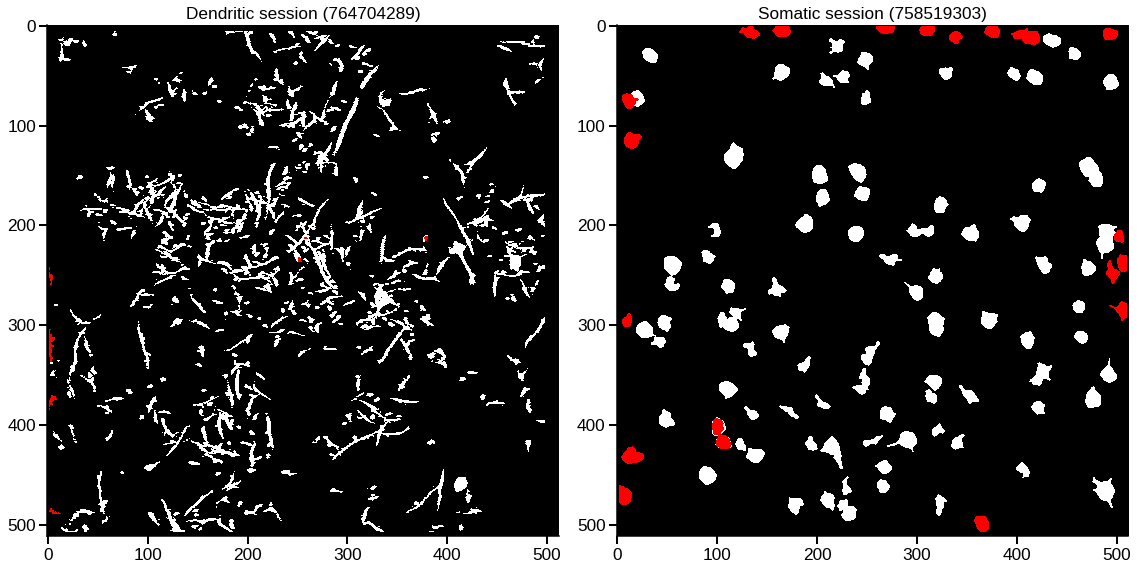

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sess_plot_util.plot_ROIs(ax[0], dend_mask_all, valid_mask=dend_valid)
_ = ax[0].set_title(f"Dendritic session ({dend_sess.sessid})")

sess_plot_util.plot_ROIs(ax[1], soma_mask_all, valid_mask=soma_valid)
_ = ax[1].set_title(f"Somatic session ({soma_sess.sessid})")

This is a tool to visualize ROI contours, optionally localized around an ROI of interest.

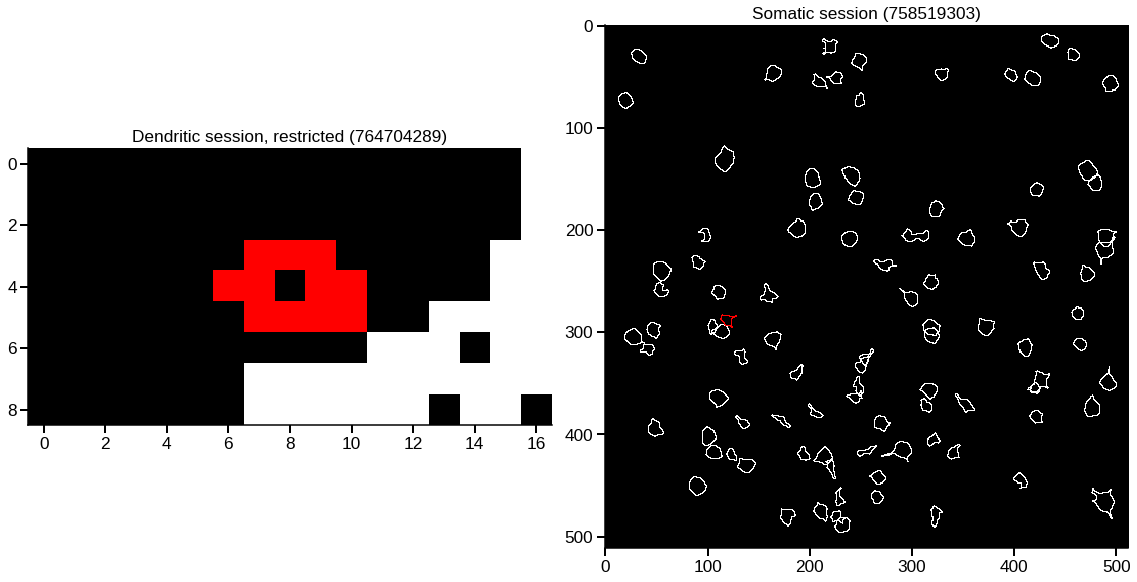

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sess_plot_util.plot_ROI_contours(ax[0], dend_mask, outlier=527, restrict=True)
_ = ax[0].set_title(f"Dendritic session, restricted ({dend_sess.sessid})")

sess_plot_util.plot_ROI_contours(ax[1], soma_mask, outlier=3)
_ = ax[1].set_title(f"Somatic session ({soma_sess.sessid})")

### 6. Last notes

List the methods/attributes attached to `Session` and `Stim` objects.

In [30]:
print(f"Session: {sess}\n{', '.join(list(filter(lambda x: ('__' not in x), dir(sess))))}")

Session: Session (758519303)
_dend, _extract_sess_attribs, _full_table, _get_roi_facts, _init_directory, _init_roi_facts_df, _load_stim_df, _load_stim_dict, _load_stims, _nanrois_dff, _nrois, _nwb, _only_tracked_rois, _roi_masks, _set_dend_type, _set_nanrois, _set_nanrois_tracked, _set_roi_attributes, _set_tracked_rois, _stim2twopfr, align_pkl, all_files, any_files, behav_video_h5, check_flanks, convert_frames, correct_data_h5, data_loaded, date, dend, depth, dir, drop_tol, expdir, expid, extract_info, gabors, get_active_rois, get_fr_ran, get_frames_timestamps, get_nanrois, get_nrois, get_plateau_roi_traces, get_pup_data, get_roi_masks, get_roi_seqs, get_roi_traces, get_run_velocity, get_run_velocity_by_fr, get_single_roi_trace, get_stim, grayscr, home, line, load_pup_data, load_roi_info, load_run_data, mouse_df, mouse_dir, mouse_n, mouseid, n_stims, notes, nwb, only_tracked_rois, pass_fail, plane, procdir, pup_data_h5, pup_video_h5, roi_extract_json, roi_facts_df, roi_mask_file, roi_m

In [31]:
print(f"Gabors: {sess}\n{', '.join(list(filter(lambda x: ('__' not in x), dir(sess.gabors))))}")

Gabors: Session (758519303)
_set_block_params, all_gabfr, all_gabfr_mean_oris, block_params, deg_per_pix, exp_gabfr, exp_gabfr_mean_oris, exp_max_s, exp_min_s, get_A_frame_1s, get_A_segs, get_all_unexp_segs, get_all_unexp_stim_fr, get_fr_by_seg, get_frames_by_criteria, get_n_fr_by_seg, get_pup_diam_data, get_pup_diam_stats_df, get_roi_data, get_roi_stats_df, get_run, get_run_data, get_run_stats_df, get_segs_by_criteria, get_segs_by_frame, get_start_unexp_segs, get_start_unexp_stim_fr_trans, get_stats_df, get_stim_beh_sub_df, get_stim_df_by_criteria, get_stim_par_by_frame, get_stim_par_by_seg, kappas, n_patches, n_segs_per_seq, ori_ran, phase, seg_len_s, sess, sf, size_ran, stim_fps, stimtype, unexp_gabfr, unexp_gabfr_mean_oris, unexp_max_s, unexp_min_s, win_size


In [32]:
print(f"Visflow: {sess}\n{', '.join(list(filter(lambda x: ('__' not in x), dir(sess.visflow))))}")

Visflow: Session (758519303)
_set_block_params, block_params, deg_per_pix, exp_max_s, exp_min_s, get_all_unexp_segs, get_all_unexp_stim_fr, get_dir_segs_exp, get_fr_by_seg, get_frames_by_criteria, get_n_fr_by_seg, get_pup_diam_data, get_pup_diam_stats_df, get_roi_data, get_roi_stats_df, get_run, get_run_data, get_run_stats_df, get_segs_by_criteria, get_segs_by_frame, get_start_unexp_segs, get_start_unexp_stim_fr_trans, get_stats_df, get_stim_beh_sub_df, get_stim_df_by_criteria, main_flow_direcs, n_squares, prop_flipped, seg_len_s, sess, speed, square_sizes, stim_fps, stimtype, unexp_max_s, unexp_min_s, win_size


In [33]:
print(f"Grayscr: {sess}\n{', '.join(list(filter(lambda x: ('__' not in x), dir(sess.grayscr))))}")

Grayscr: Session (758519303)
get_all_fr, get_start_fr, get_stop_fr, sess


List `Stim` object attribute values.

In [34]:
from pprint import pprint

In [35]:
print(f"Gabors: {sess.gabors}")
pprint(vars(sess.gabors))

Gabors: Gabors (stimulus from session 758519303)
{'all_gabfr': ['A', 'B', 'C', 'D', 'U'],
 'all_gabfr_mean_oris': [0.0, 45.0, 90.0, 135.0, 180.0, 225.0],
 'block_params':    start_seg  stop_seg  num_segs  start_time_sec  stop_time_sec  duration_sec  \
0          1      6801      6800       43.540279    2085.237221   2041.696942   

   start_frame_stim  stop_frame_stim  num_frames_stim  start_frame_twop  \
0              1800           124200           122400              1045   

   stop_frame_twop  num_frames_twop  gabor_kappa  
0            62456            61411           16  ,
 'deg_per_pix': 0.06251912565744862,
 'exp_gabfr': ['A', 'B', 'C', 'D'],
 'exp_gabfr_mean_oris': [0.0, 45.0, 90.0, 135.0],
 'exp_max_s': 90,
 'exp_min_s': 30,
 'kappas': [16],
 'n_patches': 30,
 'n_segs_per_seq': 5,
 'ori_ran': [0, 360],
 'phase': 0.25,
 'seg_len_s': 0.3,
 'sess': Session (758519303),
 'sf': 0.04,
 'size_ran': [159.9510532951381, 319.9021065902762],
 'stim_fps': 59.95049782968851,
 'stimtype'

In [36]:
print(f"Visflow: {sess.visflow}")
pprint(vars(sess.visflow))

Visflow: Visflow (stimulus from session 758519303)
{'block_params':    start_seg  stop_seg  num_segs  start_time_sec  stop_time_sec  duration_sec  \
0       6802      7822      1020     2115.262241    3136.110155   1020.847915   
1       7823      8843      1020     3166.135568    4186.983399   1020.847832   

   start_frame_stim  stop_frame_stim  num_frames_stim  start_frame_twop  \
0            126000           187200            61200             63359   
1            189000           250200            61200             94967   

   stop_frame_twop  num_frames_twop main_flow_direction  square_size  \
0            94064            30705        right (temp)          128   
1           125671            30704        left (nasal)          128   

   square_number  
0            105  
1            105  ,
 'deg_per_pix': 0.06251912565744862,
 'exp_max_s': 90,
 'exp_min_s': 30,
 'main_flow_direcs': ['left (nasal)', 'right (temp)'],
 'n_squares': [105],
 'prop_flipped': 0.25,
 'seg_len_s': 1

In [37]:
print(f"Grayscr: {sess.grayscr}")
pprint(vars(sess.grayscr))

Grayscr: Grayscr (session 758519303)
{'sess': Session (758519303)}
